# Coursework 3: Part A - RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook containing your answers. Write your answers in the cells below each question.


#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Friday 6th March, 2020**

## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

### Part 1 - Coding (70%)
In this part you will have to:

#### Part 1.1 (20%)

Implement the LSTM RNN cell.

#### Part 1.2 (30%)

- Modify the RNNModel class, such that it is a Bidirectional RNN.
- Compare vanilla RNN, GRU, LSTM, and bidirectional VS unidirectional RNNs and report their performance with respect to accuracy and time cost.

#### Part 1.3 (20%)

Then for your best model you will perform some improvements:
- In terms of architecture optimisation (number of layers, hidden state dimension)
- Better utilisation of the hidden state sequence output by the RNN, for classification.
- Report the improvements you achieved, as well as an explanation for why they worked.

### Part 2 - Theory (30%)

Here you will answer some theoretical questions about RNN training, and CTC -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

Set-up code and imports

In [0]:
import math
import os
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Data provider class definition.

Here you can give different configuration to the [mfcc function](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html). Additional keyword arguments are defined in the [melspectrogram function](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram).

One may additionally consider standardising the samples (remove mean, divide by std) or performing data augmentation, e.g., by adding low variance white or noise.

In [0]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "/data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "/data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        ########################################################################
        ## YOU MAY CONFIGURE HERE.
        ########################################################################
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)
        ########################################################################
        ## DO NOT CONFIGURE BEYOND HERE.
        ########################################################################
        
        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
!wget http://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip
!mkdir data
! mkdir data/data_speech_commands_v0.02
!unzip data_speech_commands_v0.02.zip -d /content/data/data_speech_commands_v0.02/

Load Dataset - you may vary batch size.

In [0]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "/content/data"

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

## YOU MAY CHANGE THE BATCH SIZE.
batch_size = 100


num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Part 1.1 (20%)

Finalise the LSTM cell (you can base your code on that of the GRU cell).

You are allowed to use nn.Linear.

In [0]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        self.x2h = nn.Linear(self.input_size, 4 * self.hidden_size, bias = self.bias)
        self.h2h = nn.Linear(self.hidden_size, 4 * self.hidden_size, bias = self.bias)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
            
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        hx, cx = hx # setting the hidden and cell state inputs

        # Ensuring the input is in the correct dimension
        input = input.view(-1, input.size(1))

        # Summing the inout and hidden states
        gates = self.x2h.forward(input) + self.h2h.forward(hx)
        gates = gates.squeeze()

        # Splitting into the 4 gates
        i_gate, f_gate, o_gate, g_gate = gates.chunk(4, 1)

        # Applying the activation functions
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate)
        o_gate = torch.sigmoid(o_gate)
        g_gate = torch.tanh(g_gate)

        cy = f_gate*cx + i_gate*g_gate
        hy = o_gate*torch.tanh(cy)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        # Ensuring the input is in the correct dimension
        input = input.view(-1, input.size(1))

        # Summing the input and hidden state
        gates = self.x2h(input) + self.h2h(hx)
        gates = gates.squeeze()

        # The linearity function has already been checked in the initialisation
        # Hence it must now be valid
        if self.nonlinearity == "tanh":
            hy = torch.tanh(gates)
        else:
            hy = torch.relu(gates)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
            
        return hy

    

class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        self.x2h = nn.Linear(self.input_size, 3 * self.hidden_size, bias = self.bias)
        self.h2h = nn.Linear(self.hidden_size, 3 * self.hidden_size, bias = self.bias)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        # Ensure the input size
        input = input.view(-1, input.size(1))

        # Build the two separate gates for the input and hidden states
        gates_x = self.x2h(input)
        gates_x = gates_x.squeeze()

        gates_h = self.h2h(hx)
        gates_h = gates_h.squeeze()

        x_r, x_z, x_h = gates_x.chunk(3, 1)
        h_r, h_z, h_h = gates_h.chunk(3, 1)

        # Note that these equations correspond to the lecture notes notation
        # z is input, g is the new gate and r the reset gate
        z_gate = torch.sigmoid(x_z + h_z)
        r_gate = torch.sigmoid(x_r + h_r)
        g_gate = torch.tanh(r_gate*h_h + x_h)

        hy = z_gate*hx + (1 - z_gate)*g_gate

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        return hy

In [0]:
class RNNModel(nn.Module):
    '''Please note that an output_method input has been added.
    This allows me to select how to compute the features of the final feed forward
    neural network.
    'weighted': uses the self.att_fc to learn a weight for the hidden states of 
      each frame; learning attention.
    'mean': performs the mean over all the hidden states.
    any other string: selects the last hidden state as features.''' 
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size, output_method='normal'):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.output_method = output_method
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                             self.hidden_size,
                                             self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        else:
             h0 = hx

        outs = []

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        if self.mode == 'LSTM':
            if hx is None:
                if torch.cuda.is_available():
                    c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
                else:
                    c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
                h0 = (h0, c0)
            
            # Get all the hidden states and cells at each layer
            hidden_states = [h0[0][layer, :, :] for layer in range(self.num_layers)]
            hidden_cells = [h0[1][layer, :, :] for layer in range(self.num_layers)]

            # For each signal frame
            for frame in range(input.size(1)):
                # For each layer of the RNN
                for layer in range(self.num_layers):
                    # Starting with the input
                    if layer == 0:
                        hidden = self.rnn_cell_list[layer](input[:, frame, :], 
                                                          (hidden_states[layer],
                                                           hidden_cells[layer]))
                    else:
                        hidden = self.rnn_cell_list[layer](hidden_states[layer-1],
                                                           (hidden_states[layer],
                                                            hidden_cells[layer]))
                    # Updating the values of the hidden states
                    hidden_states[layer] = hidden[0]
                    hidden_cells[layer] = hidden[1]
                
                # Storing the output of each segment
                outs.append(hidden_states[-1])
        
        
        else:
            # Get all the hidden states at each layer, there are no 'cell' to compute
            hidden_states = [h0[layer, :, :] for layer in range(self.num_layers)]

            # For each signal frame
            for frame in range(input.size(1)):
                # For each layer of the RNN
                for layer in range(self.num_layers):
                    # Starting with the input
                    if layer == 0:
                        hidden = self.rnn_cell_list[layer](input[:, frame, :], 
                                                           hidden_states[layer])
                    else:
                        hidden = self.rnn_cell_list[layer](hidden_states[layer-1],
                                                           hidden_states[layer])
                    # Updating the values of the hidden states
                    hidden_states[layer] = hidden
                
                # Storing the output of each segment
                outs.append(hidden_states[-1])


        # Aditional code for new methods in selecting the output
        if (self.output_method == 'weighted' or self.output_method == 'mean'):
            if self.output_method == 'weighted':
                # Sigmoid function to directly learn a weight between 0 and 1
                outs_tensor = [hid*torch.sigmoid(self.att_fc(hid)) for hid in outs]
                outs_tensor = torch.stack(outs_tensor)
                out = outs_tensor.sum(dim = 0) #sum as they are already weighted

            elif self.output_method == 'mean':
                outs_tensor = [hid for hid in outs]
                outs_tensor = torch.stack(outs_tensor)
                out = outs_tensor.mean(dim = 0)

        else:
            out = outs[-1].squeeze() # Related to Part 1.3.


        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = self.fc(out)
        
        return out
    

class BidirRecurrentModel(nn.Module):
    '''Please note that a similar output_method parameter has been added.'''
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size, output_method='normal'):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.output_method = output_method

        self.rnn_cell_list = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
          
        if mode == 'LSTM':
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                               self.hidden_size,
                                               self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))

        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")

        # The diffrence lies here as we concatenate the output of the 
        # forward and inverse rnns. The final hidden size is multiplied
        # by 2.
        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size*2, self.output_size)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
        if torch.cuda.is_available():
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
            
        outs = []
        outs_rev = []
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        # This section is similar to that of RNN model class
        # The difference lies in the addition of the inverse model
        
        if self.mode == 'LSTM':
            # Creating the hidden tuples
            if torch.cuda.is_available():
                c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                c0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
            if torch.cuda.is_available():
                cT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                cT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

            h0 = (h0, c0)
            hT = (hT, cT)

            # Get all the hidden states at each layer for the forward and reversed RNNs
            hidden_states = [h0[0][layer, :, :] for layer in range(self.num_layers)]
            hidden_cells = [h0[1][layer, :, :] for layer in range(self.num_layers)]

            hidden_states_reversed = [hT[0][layer, :, :] for layer in range(self.num_layers)]
            hidden_cells_reversed = [hT[1][layer, :, :] for layer in range(self.num_layers)]

            # For each frame in signal
            for frame in range(input.size(1)):
                # For each layer of the RNN
                for layer in range(self.num_layers):
                    # Starting with the raw input
                    if layer == 0:
                        hidden = self.rnn_cell_list[layer](input[:, frame, :], 
                                                           (hidden_states[layer], 
                                                            hidden_cells[layer]))
                        # Taking the frames in reversed 
                        hidden_reversed = self.rnn_cell_list[layer](input[:, -frame - 1, :],
                                                                    (hidden_states_reversed[layer],
                                                                     hidden_cells_reversed[layer]))
                    else:
                        hidden = self.rnn_cell_list[layer](hidden_states[layer-1],
                                                           (hidden_states[layer], 
                                                            hidden_cells[layer]))
                        
                        hidden_reversed = self.rnn_cell_list[layer](hidden_states_reversed[layer-1],
                                                                   (hidden_states_reversed[layer], 
                                                                    hidden_cells_reversed[layer])) 
                    
                    # Updating the values of the hidden states
                    hidden_states[layer] = hidden[0]
                    hidden_cells[layer] = hidden[1]

                    hidden_states_reversed[layer] = hidden_reversed[0]
                    hidden_cells_reversed[layer] = hidden_reversed[1]

                # Storing the output of each segment
                outs.append(hidden_states[-1])
                outs_rev.append(hidden_states_reversed[-1])


        else:
            # Get all the hidden states at each layer for the forward and reversed RNNs
            hidden_states = [h0[layer, :, :] for layer in range(self.num_layers)]
            hidden_states_reversed = [hT[layer, :, :] for layer in range(self.num_layers)]

            # For each frame in signal
            for frame in range(input.size(1)):
                # For each layer of the RNN
                for layer in range(self.num_layers):
                    # Starting with the raw input
                    if layer == 0:
                        hidden = self.rnn_cell_list[layer](input[:, frame, :], 
                                                          hidden_states[layer])
                        # Taking the frames in reversed 
                        hidden_reversed = self.rnn_cell_list[layer](input[:, -frame - 1, :],
                                                                    hidden_states_reversed[layer])
                    else:
                        hidden = self.rnn_cell_list[layer](hidden_states[layer-1],
                                                          hidden_states[layer])
                        
                        hidden_reversed = self.rnn_cell_list[layer](hidden_states_reversed[layer-1],
                                                          hidden_states_reversed[layer]) 
                    
                    # Updating the values of the hidden states
                    hidden_states[layer] = hidden
                    hidden_states_reversed[layer] = hidden_reversed

                # Storing the output of each segment
                outs.append(hidden_states[-1])
                outs_rev.append(hidden_states_reversed[-1])


        # Chosing the different weitghting methods
        if (self.output_method == 'weighted' or self.output_method == 'mean'):
            if self.output_method == 'weighted':
                outs_tensor = [hid*torch.sigmoid(self.att_fc(hid)) for hid in outs]
                outs_tensor_rev = [hid*torch.sigmoid(self.att_fc(hid)) for hid in outs_rev]
                outs_tensor = torch.stack(outs_tensor)
                outs_tensor_rev = torch.stack(outs_tensor_rev)
                out = outs_tensor.sum(dim = 0)
                out_rev = outs_tensor_rev.sum(dim = 0)

            else:
                outs_tensor = [hid for hid in outs]
                outs_tensor_rev = [hid for hid in outs_rev]
                outs_tensor = torch.stack(outs_tensor)
                outs_tensor_rev = torch.stack(outs_tensor_rev)
                out = outs_tensor.mean(dim = 0)
                out_rev = outs_tensor_rev.mean(dim = 0)

        else:
            # Taking the hidden state after having seen the whole frame sequence
            out = outs[-1].squeeze()
            out_rev = outs_rev[-1].squeeze()
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = torch.cat((out, out_rev), 1)

        out = self.fc(out)
        return out

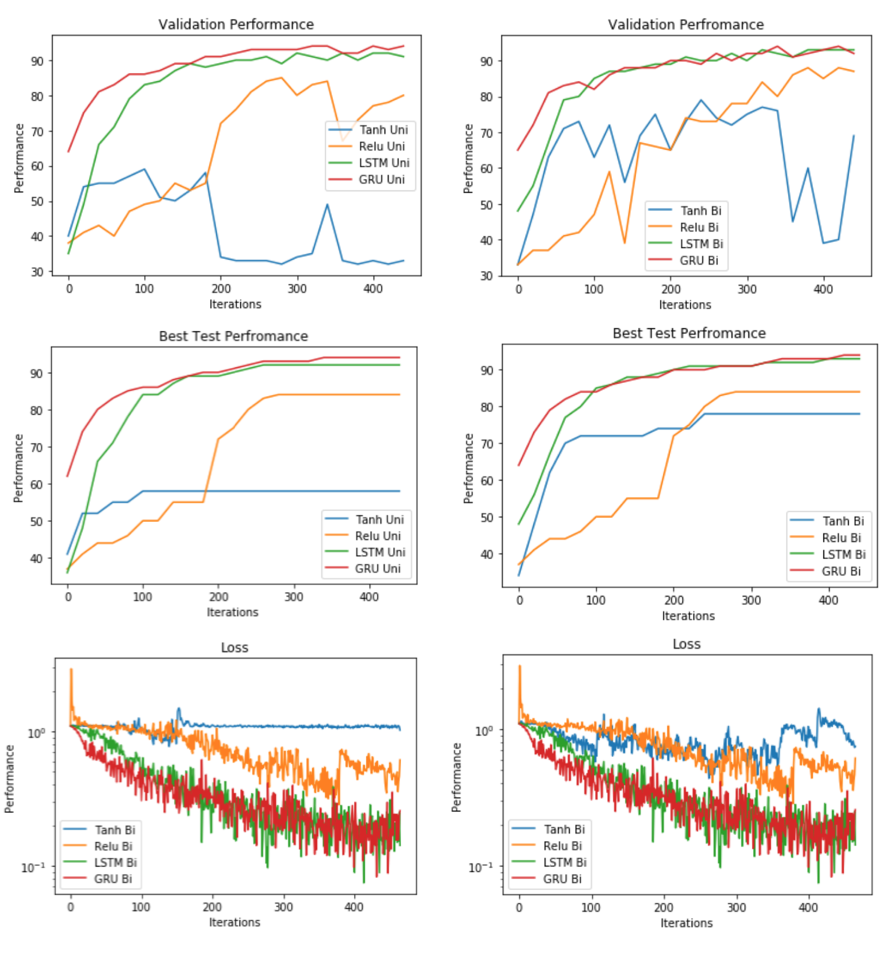

In [6]:
# Figure 1, performance and loss results

from IPython.display import Image, display
display(Image(filename='results.png', width=850))

## Part 1.2 (30%)

In the following, experiment with different RNN architectures (RNN cell types, number of layers, hidden state dimensionality, MFCC configuration, unidirectional VS bidirectional) and report the accuracy (pay also attention to the training and validation cost), as well as training time. 

* What are your justifications for these results?
In this section, I explored the classification performance of the network with different RNN cell types, number of layers and directional set-ups. 




In my analysis, I have found that using 3 hidden layers performed systematically better than using 1 only, independently of the rest of the parameters. I have also discovered that a learning rate of 0.003 perfromed better than one of 0.01 in each cases, especially in the vanilla RNNs and that using a hidden dimension of 32 perfromed very well. Hence, I have decided to plot the results of my analysis using 3 hidden layers and a learning rate of 0.003 to describe the effects of the hidden cell types and the directionality used.

The results plotted above reveal the results of my experiments (please refer to the png in the zip if the image doesn't appear above). From the validation and test plots, it is clear that the GRU and LSTM cells perform much better than the Vanilla RNN. Indeed, they reach perfromances above 90% vs less than 85 for vanilla RNN. This behaviour was expected as they respectively have 3 and 4 times more parameters to learn than the plain RNN, which allows them to learn more, and more complex data. 

On the other hand, it is seen that the bidirectionality did not systematically improve the results from uni-directionality. It soleley did for the TANH RNN, improving from $\sim$ 35 to $\sim$ 75 as best test performance. This observation is specific to this task and suggests that adding the infromation from the inverse network did not particularly help. This observation is quite surprinsing as one would think that additional information from the reversed network would help to correclty classify the signal as it would get information from both the past and future frames in the data.

Finally, the loss curves highlight the idea that the LSTM and GRU could keep on learning as they continue decreasing, while the TANH RNN has long stopped learning. In the uni-directional setting, the latter behaviour could be due to the vanishing gradients problem. Indeed, the RELU RNN has the same number of parameters than the TANH RNN but did not stop learning. Hence, the multiplication of the TANH fucntion grandients could be responsible for the loss converging rapidly to 0. RELU reduces this problem by having a gradient of 1 when positive, simply passing the gradient rather than multiplying it. On the other hand, the bi-directional setting in the TANH case might exhibhit the exploding gradients probelm. Indeed, the loss plot of the blue curve (TANH) starts to become cyclical and its validation performance drastically dropped. These are typical observations for exploding gradients, as they promote numerical instability. 

Then, the time taken per model is shown in the graph below. It is important to note that the models should have been ran multiple times and the duration averaged to be more significant, as repeating the experiments did not provide the same durations. For instance, the GRU unidirectional time seems very short when compared to that of the LSTM (the difference would be expected to be smaller), and might simply be due to a different number of processes runnning when it was recorded. 

The plot trends shows that the LSTM and GRU took longer to train than the two vanilla RNN: more than 695s vs less than 685s respectively. This result was expected as the former have more parameters to learn. Considering both time and performance, it appears that my best model is the unidirectional GRU which reaches an 93% accuracy in 695s. This plot also highligts that in our specific task, bidirectionality increases the duration of learning without significantly increasing the perfromance.  

The following cell exhibits a run a uni-directional GRU, and this model was selected to pursue the experimentations.

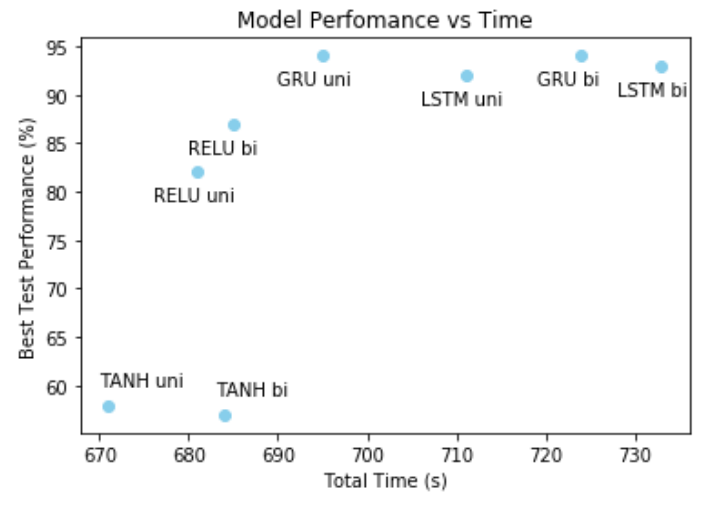

In [5]:
# Figure 2, performance time results

from IPython.display import Image, display
display(Image(filename='performance_time_results.png', width=500))

In [0]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch
import time
seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 32
layer_dim = 3
bias = True

model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim, 'normal')
# model = BidirRecurrentModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim, 'normal')

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0

### For my performance and time
#start_time = time.time()
# v_accuracies = []
# t_accuracies = []
# name = 'GRU_3_32_003_uni'

for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy
            
            ## For my plots
            #v_accuracies.append(v_accuracy)
            #t_accuracies.append(reported_t_accuracy)

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))

##### For my plots
# end_time = time.time()
# time_taken = end_time-start_time
# print(time_taken)

# These were ran to save the values which I have then used for my plots
# np.save('loss'+name, np.array(loss_list))
# np.save('val'+name, np.array(v_accuracies))
# np.save('test'+name, np.array(t_accuracies))

Iteration: 40. Loss: 0.873515784740448. V-Accuracy: 58  T-Accuracy: 57
Iteration: 20. Loss: 0.999224066734314. V-Accuracy: 49  T-Accuracy: 50
Iteration: 60. Loss: 0.6377328634262085. V-Accuracy: 76  T-Accuracy: 74
Iteration: 80. Loss: 0.5273351073265076. V-Accuracy: 79  T-Accuracy: 79
Iteration: 100. Loss: 0.5595822334289551. V-Accuracy: 82  T-Accuracy: 81
Iteration: 120. Loss: 0.3253061771392822. V-Accuracy: 86  T-Accuracy: 86
Iteration: 140. Loss: 0.34277188777923584. V-Accuracy: 86  T-Accuracy: 87
Iteration: 160. Loss: 0.23527474701404572. V-Accuracy: 89  T-Accuracy: 90
Iteration: 180. Loss: 0.19602395594120026. V-Accuracy: 89  T-Accuracy: 90
Iteration: 200. Loss: 0.24501481652259827. V-Accuracy: 89  T-Accuracy: 90
Iteration: 220. Loss: 0.2395639419555664. V-Accuracy: 91  T-Accuracy: 91
Iteration: 240. Loss: 0.1810225248336792. V-Accuracy: 91  T-Accuracy: 92
Iteration: 260. Loss: 0.22398918867111206. V-Accuracy: 90  T-Accuracy: 92
Iteration: 280. Loss: 0.18407787382602692. V-Accurac

## Part 1.3 (20%)

RNN hidden state. In the code above in the RNNModel and BidirRecurrentModel, we utilise the final hidden state extracted by the model in order to make the final pass through a feed-forward layer towards a final prediction.

a) Can you think of reasons this might not be the best choice? Please write down two variations that could possibly yield better result.

b) Experiment with such alternative approaches in the code below in order to achieve a better result and report it below.

**a)** 

Utilising only the final hidden state extracted by the model might not be the best choice as the most important information in the data might lie far away from the last frame, and the accumulation of posterior sequences could corrupt this inofrmation. Moreover, the characteristic information could be spread over the different frames and it could be benificial to explicitly use all of the frames to make the final prediciton. 

For instance, in such audio signal recordings, the first and final frames of the sequence might correspond to noise. Hence, in a unidirectional or a bidirectional setting, the prediction would be soleley based on a signal sequence which would not be the most informative.

Two variations that could provide better results are:
  - Taking the **mean of the hidden states** over time. This method would give as much importance to each frame in the signal when classifying. This could ensure that the classification does not rely on the final hidden state only, and that the frame with most importance is taken into account when making the prediction.
  - Using an **attention mechanism** to weight each sequence in the signal prior to summing them acccording to these weights, and then passing them through the feed froward network. This would allow to learn a weight for each sequence and to help the network focus on the sequences which hold the most importance.


  **b)**

The mean and attention mechanisms have been added to my RNN Class and Biderectional Class and can be selected via the 'output_method' when creating the model: 'mean' and 'weighted' respectively. 

I decided to test these mechanism on both the unidirectional and bidirectional settings with my best model: GRU, hidden dimension of 32, layer dimension of 3, learning rate of 0.003. The attention mechanism performed better than the mean and the usual output method, reaching an accuracy of 94% in 780s when using the bidirectional RNN. The network has been ran below and exhibits the reults.
This slight increase of performance has been achieved thanks to the additional parameters added in the network. The latter enabled the network to: converge faster and reach a better perormance. (The total duration was also increased due to these new parametersto learn.) This resulst was expected as the additional parameters enable the network to focus on the most important hidden states, potentially retrieving more significant information for classification.

In [0]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

# Add the model that has got the best results for you after after Part 1.2 and Part 1.3

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 32
layer_dim = 3
bias = True

# model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim, output_method='mean')
model = BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim, output_method='weighted')

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))

Iteration: 20. Loss: 0.784145712852478. V-Accuracy: 56  T-Accuracy: 56
Iteration: 40. Loss: 0.632258951663971. V-Accuracy: 74  T-Accuracy: 74
Iteration: 60. Loss: 0.5867458581924438. V-Accuracy: 75  T-Accuracy: 75
Iteration: 80. Loss: 0.46956539154052734. V-Accuracy: 79  T-Accuracy: 79
Iteration: 100. Loss: 0.41880521178245544. V-Accuracy: 81  T-Accuracy: 82
Iteration: 120. Loss: 0.41098058223724365. V-Accuracy: 85  T-Accuracy: 84
Iteration: 140. Loss: 0.2922861576080322. V-Accuracy: 88  T-Accuracy: 87
Iteration: 160. Loss: 0.19629687070846558. V-Accuracy: 91  T-Accuracy: 91
Iteration: 180. Loss: 0.20755572617053986. V-Accuracy: 92  T-Accuracy: 91
Iteration: 200. Loss: 0.24980680644512177. V-Accuracy: 93  T-Accuracy: 93
Iteration: 220. Loss: 0.29252973198890686. V-Accuracy: 91  T-Accuracy: 93
Iteration: 240. Loss: 0.14221879839897156. V-Accuracy: 93  T-Accuracy: 93
Iteration: 260. Loss: 0.19644759595394135. V-Accuracy: 93  T-Accuracy: 93
Iteration: 280. Loss: 0.09592826664447784. V-Acc

## Part 2: Theoretical questions (30%)

Please answer the following theoretical questions in a cell below each respective question.

a. What is the _vanishing and exploding gradients problem_? When does it appear, and what is its practical significance? Please explain. (10%)

The vanishing and exploding gradients probelm are two phenomena which can occur when training deep networks, where the gradient of the loss function with respect to the weights respectively decreases to 0 or explodes to infinity (or simply high values).

The vanishing gradients drive the weight update to 0 in between each optimsation step, which makes the network parameters stabilise at a sub-optimal solution and prevents it from learning anymore. \
The exploding gradients can lead to numerical overflow or irregular oscillations in the loss function plots, similarly preventing learning. These two problems hinder the network from efficiently learning from the data and the perfromance loses its significant.

This problem is a direct consequence from the repeated matrix multipications, and appears specifically in deep neural networks and RNN. In the latter, the depth of the network and the number of the input sequences can lead to a significant number of matrix multiplications during backpropagation. By thinking about the eigen value decompostion of the jacobian matrices (which in the case of the RNN are the gradients of one time step hidden values with respcet to the previous), it is seen that the value of the change $\Delta h_t$ will be dominated by the largest eigen value. Thus as the latter deviates from 1 the total matrix multiplication will grow or decrease exponentially with it (to the power of the timesteps). Consequently, the gradient will vanish or explode leading to the described problems.

Other than hindering the learning, this probelm has practical significance as it concerns deep models, which are the ones which can most efficiently respresent complex and non linear data. Hence it is necessary to find solutions to circumvent it. In the case of exploding gradients, clippling the latter to 1 could solve the problem, whilst changing the architecture of the network could prove beneficial for vanishing gradients (for instance: from RNN to LSTM). 



b. The following (cartoon) plots show the gradients and the training curves for three models A, B, and C, trained on the same dataset. The three models are a RNN, a LSTM and a GRU, not necessarily in that order. (10%)

* Which could plausibly be which? Why? Please explain your reasoning.
* For which kinds of problems would you elect to use each of them?


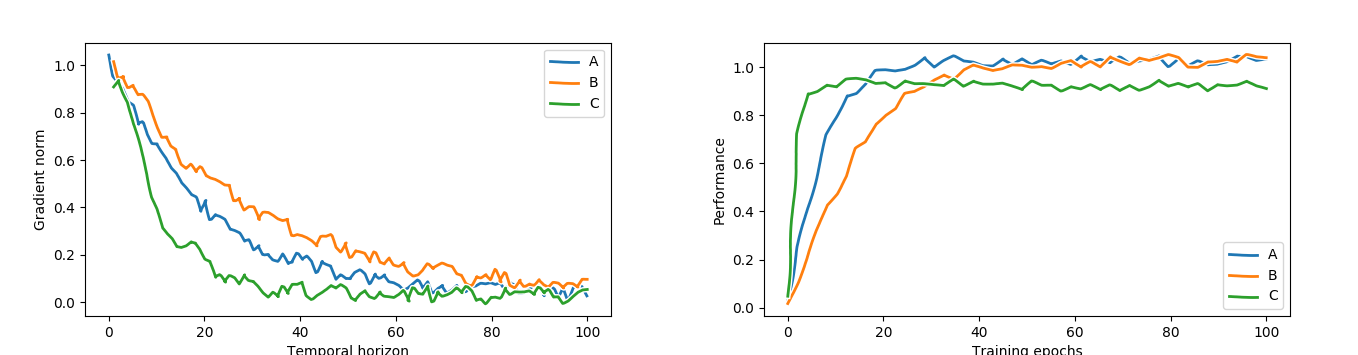

In [0]:
from IPython.display import Image, display
display(Image(filename='question_figs.png', width=850))

A plausible attribution of each curve would be:
  - A: GRU 
  - B: LSTM
  - C: RNN

The reasoning is straightforward: the LSTM and GRU respectively have 4 and 3 times as many parameters of the plain RNN (used to represent the gates). Hence, the LSTM and GRU will be more expressive than the RNN and will be able to perform significantly better. This idea is revealed in the right hand side performance plot which enables to decipher that models A and C should correspond to GRU and LSTM, whilst model B should be the RNN. 

To differentiate between the models, the time to convergence is also explored. The left hand side plot revelas the time to convergence as the gradient of the norm will tend to 0 when the network converges. The two plots suggest that model A converges faster than model B. This suggests that model A corresponds to GRU as it has 25% less parameters than the LSTM. Moreover, the fact that model C converges much faster than the two others (less than 20 epochs vs more than 30 respectively) strengthens the idea that it correpsonds to RNN, where less parameters are to learn. 

In addition, in ceratin tasks and above a certain threshold, increasing the number of parameters even more does not significantly increase performance. This result is highlighted by the orange and blue curves on the right hand side plot which approximately provide the same performance. This reinforces the possibility of having model A as GRU, which converges faster but performs as well as the model B: LSTM.



c.  Write down five possible Connectionist Temporal Classification (CTC) paths (of no more than a length of eight) that correspond to the same label "LADDER". (10%)

The dash symbol: - is used as a time step.



1. LAD-DER
2. LAAD-DER
3. LAD-DDER
4. LAD-DEER
5. L-AD-DER


